```
================================================================================
SECCIÓN 4: APRENDIZAJE SUPERVISADO (TAREAS 13, 14, 15, 16, 17)
================================================================================
OBJETIVO: Entrenar y evaluar modelos de clasificación supervisada para predecir
el nivel de desempeño en inglés (DESEMP_INGLES) a partir de las variables
preprocesadas.
================================================================================
```

In [1]:
# ============================================
# CONFIGURACIÓN INICIAL E IMPORTACIONES
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import json
from time import time

# Scikit-learn imports - Modelos
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Métricas y validación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, matthews_corrcoef
)
from sklearn.model_selection import (
    cross_val_score, cross_validate, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
TARGET_COLUMN = 'DESEMP_INGLES'
np.random.seed(RANDOM_STATE)

print("="*80)
print("SECCIÓN 4: APRENDIZAJE SUPERVISADO")
print("="*80)
print(f"📌 Random State: {RANDOM_STATE}")
print(f"🎯 Variable Objetivo: {TARGET_COLUMN}\n")

SECCIÓN 4: APRENDIZAJE SUPERVISADO
📌 Random State: 42
🎯 Variable Objetivo: DESEMP_INGLES



In [2]:
# ============================================
# CARGAR DATOS PREPROCESADOS
# ============================================

print("="*80)
print("CARGANDO DATOS PREPROCESADOS DE SECCIÓN 2")
print("="*80 + "\n")

try:
    # Cargar train/test split
    with open('../data/processed/train_test_split.pkl', 'rb') as f:
        train_test_data = pickle.load(f)
    
    X_train = train_test_data['X_train']
    X_test = train_test_data['X_test']
    y_train = train_test_data['y_train']
    y_test = train_test_data['y_test']
    y_train_original = train_test_data['y_train_original']
    y_test_original = train_test_data['y_test_original']
    
    print(f"✅ X_train: {X_train.shape}")
    print(f"✅ X_test: {X_test.shape}")
    print(f"✅ y_train: {y_train.shape}")
    print(f"✅ y_test: {y_test.shape}")
    
    # Cargar objetos de preprocesamiento
    with open('../data/processed/preprocessing_objects.pkl', 'rb') as f:
        preprocessing_objects = pickle.load(f)
    
    le_target = preprocessing_objects['label_encoder_target']
    target_mapping = preprocessing_objects['target_mapping']
    final_features = preprocessing_objects['final_features']
    
    print(f"\n✅ Mapeo de clases: {target_mapping}")
    print(f"✅ Features: {len(final_features)}")
    
    # Cargar PCA (opcional)
    try:
        with open('../data/processed/pca_models.pkl', 'rb') as f:
            pca_objects = pickle.load(f)
        X_train_pca = pca_objects['X_train_pca']
        X_test_pca = pca_objects['X_test_pca']
        optimal_n_components = pca_objects['optimal_n_components']
        print(f"✅ PCA disponible: {optimal_n_components} componentes")
    except:
        X_train_pca = None
        X_test_pca = None
        print("⚠️  PCA no disponible")
        
except Exception as e:
    print(f"❌ Error cargando datos: {e}")
    print("⚠️  Ejecuta primero la Sección 2 (Preprocesamiento)")
    raise

# Verificar distribución de clases
print("\n📊 DISTRIBUCIÓN DE CLASES:")
for i, label in enumerate(le_target.classes_):
    n_train = np.sum(y_train == i)
    n_test = np.sum(y_test == i)
    pct_train = n_train / len(y_train) * 100
    pct_test = n_test / len(y_test) * 100
    print(f"   {label}: Train={n_train:,} ({pct_train:.1f}%), Test={n_test:,} ({pct_test:.1f}%)")

print("\n✅ Datos cargados correctamente")

CARGANDO DATOS PREPROCESADOS DE SECCIÓN 2

✅ X_train: (152306, 20)
✅ X_test: (65275, 20)
✅ y_train: (152306,)
✅ y_test: (65275,)

✅ Mapeo de clases: {'A-': 0, 'A1': 1, 'A2': 2, 'B+': 3, 'B1': 4}
✅ Features: 20
✅ PCA disponible: 8 componentes

📊 DISTRIBUCIÓN DE CLASES:
   A-: Train=75,424 (49.5%), Test=32,325 (49.5%)
   A1: Train=42,882 (28.2%), Test=18,378 (28.2%)
   A2: Train=22,228 (14.6%), Test=9,527 (14.6%)
   B+: Train=2,035 (1.3%), Test=872 (1.3%)
   B1: Train=9,737 (6.4%), Test=4,173 (6.4%)

✅ Datos cargados correctamente


In [3]:
# ============================================
# TAREA 13: ENTRENAMIENTO DE MODELOS
# ============================================

print("\n\n" + "="*80)
print("TAREA 13: ENTRENAMIENTO DE MODELOS DE CLASIFICACIÓN")
print("="*80 + "\n")

"""
Entrenaremos múltiples modelos de clasificación:
1. Decision Tree - Modelo interpretable basado en reglas
2. Random Forest - Ensemble de árboles de decisión
3. Logistic Regression - Modelo lineal probabilístico
4. Support Vector Machine (SVM) - Modelo de margen máximo
5. K-Nearest Neighbors (KNN) - Modelo basado en instancias
"""

# Diccionario para almacenar modelos y resultados
models = {}
predictions = {}
training_times = {}

# ==================
# MODELO 1: DECISION TREE
# ==================

print("13.1 DECISION TREE CLASSIFIER")
print("-" * 80 + "\n")

print("Configuración:")
print("   • max_depth = 15")
print("   • min_samples_split = 100")
print("   • min_samples_leaf = 50")
print("   • criterion = 'gini'")

start_time = time()
dt_model = DecisionTreeClassifier(
    max_depth=15,
    min_samples_split=100,
    min_samples_leaf=50,
    criterion='gini',
    random_state=RANDOM_STATE
)
dt_model.fit(X_train, y_train)
dt_time = time() - start_time

models['Decision Tree'] = dt_model
predictions['Decision Tree'] = dt_model.predict(X_test)
training_times['Decision Tree'] = dt_time

print(f"\n✅ Decision Tree entrenado en {dt_time:.2f}s")
print(f"   • Número de nodos: {dt_model.tree_.node_count}")
print(f"   • Profundidad del árbol: {dt_model.tree_.max_depth}")

# ==================
# MODELO 2: RANDOM FOREST
# ==================

print("\n\n13.2 RANDOM FOREST CLASSIFIER")
print("-" * 80 + "\n")

print("Configuración:")
print("   • n_estimators = 100")
print("   • max_depth = 15")
print("   • min_samples_split = 50")
print("   • min_samples_leaf = 25")

start_time = time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=25,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_time = time() - start_time

models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_model.predict(X_test)
training_times['Random Forest'] = rf_time

print(f"\n✅ Random Forest entrenado en {rf_time:.2f}s")
print(f"   • Número de árboles: {rf_model.n_estimators}")

# ==================
# MODELO 3: LOGISTIC REGRESSION
# ==================

print("\n\n13.3 LOGISTIC REGRESSION")
print("-" * 80 + "\n")

print("Configuración:")
print("   • solver = 'lbfgs'")
print("   • max_iter = 1000")
print("   • multi_class = 'multinomial'")

start_time = time()
lr_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    multi_class='multinomial',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lr_model.fit(X_train, y_train)
lr_time = time() - start_time

models['Logistic Regression'] = lr_model
predictions['Logistic Regression'] = lr_model.predict(X_test)
training_times['Logistic Regression'] = lr_time

print(f"\n✅ Logistic Regression entrenado en {lr_time:.2f}s")

# ==================
# MODELO 4: SUPPORT VECTOR MACHINE
# ==================

print("\n\n13.4 SUPPORT VECTOR MACHINE (SVM)")
print("-" * 80 + "\n")

print("Configuración:")
print("   • kernel = 'rbf'")
print("   • C = 1.0")
print("   • gamma = 'scale'")
print("⚠️  Usando muestra de 20,000 observaciones por eficiencia...\n")

# SVM es costoso, usar muestra
sample_indices = np.random.choice(len(X_train), min(20000, len(X_train)), replace=False)
X_train_svm = X_train.iloc[sample_indices]
y_train_svm = y_train.iloc[sample_indices]

start_time = time()
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=RANDOM_STATE
)
svm_model.fit(X_train_svm, y_train_svm)
svm_time = time() - start_time

models['SVM'] = svm_model
predictions['SVM'] = svm_model.predict(X_test)
training_times['SVM'] = svm_time

print(f"✅ SVM entrenado en {svm_time:.2f}s")
print(f"   • Support vectors: {svm_model.n_support_.sum()}")

# ==================
# MODELO 5: K-NEAREST NEIGHBORS
# ==================

print("\n\n13.5 K-NEAREST NEIGHBORS (KNN)")
print("-" * 80 + "\n")

print("Configuración:")
print("   • n_neighbors = 7")
print("   • weights = 'distance'")
print("   • metric = 'euclidean'")

start_time = time()
knn_model = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)
knn_model.fit(X_train, y_train)
knn_time = time() - start_time

models['KNN'] = knn_model
predictions['KNN'] = knn_model.predict(X_test)
training_times['KNN'] = knn_time

print(f"\n✅ KNN entrenado en {knn_time:.2f}s")

# Resumen
print("\n\n" + "="*80)
print("RESUMEN DE ENTRENAMIENTO")
print("="*80 + "\n")

for model_name, t in training_times.items():
    print(f"   {model_name:20s}: {t:7.2f}s")

print("\n" + "="*80)
print("✅ TAREA 13 COMPLETADA")
print("="*80)



TAREA 13: ENTRENAMIENTO DE MODELOS DE CLASIFICACIÓN

13.1 DECISION TREE CLASSIFIER
--------------------------------------------------------------------------------

Configuración:
   • max_depth = 15
   • min_samples_split = 100
   • min_samples_leaf = 50
   • criterion = 'gini'

✅ Decision Tree entrenado en 0.53s
   • Número de nodos: 4121
   • Profundidad del árbol: 15


13.2 RANDOM FOREST CLASSIFIER
--------------------------------------------------------------------------------

Configuración:
   • n_estimators = 100
   • max_depth = 15
   • min_samples_split = 50
   • min_samples_leaf = 25

✅ Random Forest entrenado en 2.31s
   • Número de árboles: 100


13.3 LOGISTIC REGRESSION
--------------------------------------------------------------------------------

Configuración:
   • solver = 'lbfgs'
   • max_iter = 1000
   • multi_class = 'multinomial'

✅ Logistic Regression entrenado en 14.91s


13.4 SUPPORT VECTOR MACHINE (SVM)
-----------------------------------------------------

In [ ]:
# ============================================
# TAREA 14: COMPARACIÓN DE MODELOS
# ============================================

print("\n\n" + "="*80)
print("TAREA 14: COMPARACIÓN DE MODELOS CON MÉTRICAS")
print("="*80 + "\n")

# Calcular métricas para cada modelo
metrics_results = {}

for model_name in models.keys():
    y_pred = predictions[model_name]
    
    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    # Para multi-clase, usar 'weighted' average
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    metrics_results[model_name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Training Time': training_times[model_name]
    }

# Crear DataFrame de comparación
metrics_df = pd.DataFrame(metrics_results).T
metrics_df = metrics_df.sort_values('F1-Score', ascending=False)

print("📊 TABLA COMPARATIVA DE MÉTRICAS:\n")
print(metrics_df.to_string())

# Visualización de comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
metrics_df['Accuracy'].plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_xlabel('Accuracy', fontweight='bold')
axes[0, 0].set_title('Comparación de Accuracy', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_df['Accuracy']):
    axes[0, 0].text(v + 0.005, i, f'{v:.4f}', va='center')

# 2. F1-Score comparison
metrics_df['F1-Score'].plot(kind='barh', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
axes[0, 1].set_title('Comparación de F1-Score', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_df['F1-Score']):
    axes[0, 1].text(v + 0.005, i, f'{v:.4f}', va='center')

# 3. Precision vs Recall
axes[1, 0].scatter(metrics_df['Precision'], metrics_df['Recall'], s=200, alpha=0.6)
for idx, model in enumerate(metrics_df.index):
    axes[1, 0].annotate(model, 
                       (metrics_df['Precision'].iloc[idx], metrics_df['Recall'].iloc[idx]),
                       fontsize=9, ha='center')
axes[1, 0].set_xlabel('Precision', fontweight='bold')
axes[1, 0].set_ylabel('Recall', fontweight='bold')
axes[1, 0].set_title('Precision vs Recall', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 4. Training Time
metrics_df['Training Time'].plot(kind='barh', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_xlabel('Tiempo (segundos)', fontweight='bold')
axes[1, 1].set_title('Tiempo de Entrenamiento', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_df['Training Time']):
    axes[1, 1].text(v + 0.5, i, f'{v:.2f}s', va='center')

plt.tight_layout()
plt.savefig('../outputs/seccion4/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Matrices de confusión
print("\n\n14.2 MATRICES DE CONFUSIÓN\n")
print("-" * 80 + "\n")

n_models = len(models)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalizar por fila (porcentajes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=le_target.classes_,
                yticklabels=le_target.classes_,
                ax=axes[idx], cbar=True)
    
    axes[idx].set_title(f'{model_name}\n(Acc: {metrics_results[model_name]["Accuracy"]:.4f})', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Real', fontweight='bold')
    axes[idx].set_xlabel('Predicho', fontweight='bold')

# Hide last subplot if odd number of models
if n_models < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.savefig('../outputs/seccion4/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification reports
print("\n14.3 REPORTES DE CLASIFICACIÓN DETALLADOS\n")
print("-" * 80 + "\n")

for model_name, y_pred in predictions.items():
    print(f"\n{'='*80}")
    print(f"MODELO: {model_name}")
    print(f"{'='*80}\n")
    print(classification_report(y_test, y_pred, 
                                target_names=le_target.classes_,
                                digits=4))

# ============================================
# 14.5 CURVAS ROC-AUC (MULTICLASE)
# ============================================

print("\n\n" + "="*80)
print("14.5 CURVAS ROC-AUC MULTICLASE")
print("="*80 + "\n")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarizar las etiquetas para análisis multiclase (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=sorted(y_test.unique()))
n_classes = y_test_bin.shape[1]

print(f"📊 Configuración: {n_classes} clases (One-vs-Rest)")
print(f"   Clases: {sorted(y_test.unique())}\n")

# Calcular ROC-AUC para cada modelo
roc_results = {}

for model_name, model in models.items():
    print(f"Calculando ROC-AUC para {model_name}...", end=' ')
    
    try:
        # Obtener probabilidades predichas
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_pred_proba = model.decision_function(X_test)
        else:
            print("✗ No disponible (sin predict_proba)")
            continue
        
        # Calcular ROC para cada clase
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Calcular micro-average ROC
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Calcular macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        roc_results[model_name] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
        
        print(f"✓ Macro-AUC={roc_auc['macro']:.4f}, Micro-AUC={roc_auc['micro']:.4f}")
        
    except Exception as e:
        print(f"✗ Error: {str(e)[:40]}")

# Visualización de curvas ROC
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.ravel()

class_names = sorted(y_test.unique())
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for idx, (model_name, results) in enumerate(roc_results.items()):
    if idx >= 6:  # Máximo 6 modelos
        break
    
    ax = axes[idx]
    
    # Plot micro-average
    ax.plot(results['fpr']['micro'], results['tpr']['micro'],
            label=f'Micro-average (AUC={results["roc_auc"]["micro"]:.3f})',
            color='deeppink', linestyle='--', linewidth=3)
    
    # Plot macro-average
    ax.plot(results['fpr']['macro'], results['tpr']['macro'],
            label=f'Macro-average (AUC={results["roc_auc"]["macro"]:.3f})',
            color='navy', linestyle='--', linewidth=3)
    
    # Plot por clase
    colors_iter = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors_iter):
        ax.plot(results['fpr'][i], results['tpr'][i], color=color, lw=2,
                label=f'Clase {class_names[i]} (AUC={results["roc_auc"][i]:.3f})')
    
    # Línea diagonal (clasificador aleatorio)
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.5)')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontweight='bold')
    ax.set_title(f'{model_name}', fontweight='bold', fontsize=12)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(alpha=0.3)

# Ocultar ejes vacíos
for idx in range(len(roc_results), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('../outputs/seccion4/roc_curves_multiclass.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Guardado: roc_curves_multiclass.png")

# Tabla comparativa de AUC
print("\n📊 COMPARACIÓN ROC-AUC POR MODELO")
print("="*80)

auc_comparison = []
for model_name, results in roc_results.items():
    auc_comparison.append({
        'Modelo': model_name,
        'Macro-AUC': results['roc_auc']['macro'],
        'Micro-AUC': results['roc_auc']['micro']
    })

auc_df = pd.DataFrame(auc_comparison).sort_values('Macro-AUC', ascending=False)
print(auc_df.to_string(index=False))

# Mejor modelo por AUC
best_model_auc = auc_df.iloc[0]
print(f"\n🏆 Mejor modelo por Macro-AUC: {best_model_auc['Modelo']}")
print(f"   Macro-AUC: {best_model_auc['Macro-AUC']:.4f}")
print(f"   Micro-AUC: {best_model_auc['Micro-AUC']:.4f}")

print("\n" + "="*80)
print("✅ ANÁLISIS ROC-AUC COMPLETADO")
print("="*80)

print("\n" + "="*80)
print("✅ TAREA 14 COMPLETADA")
print("="*80)



TAREA 15: VALIDACIÓN CRUZADA Y ANÁLISIS DE ESTABILIDAD

15.1 CONFIGURACIÓN DE K-FOLD CROSS-VALIDATION
--------------------------------------------------------------------------------

Configuración: 5-Fold Stratified Cross-Validation
   • Número de folds: 5
   • Estratificación: Sí
   • Shuffle: Sí

15.2 EJECUTANDO VALIDACIÓN CRUZADA

--------------------------------------------------------------------------------

Evaluando Decision Tree...
   ✅ Completado en 2.80s

Evaluando Random Forest...
   ✅ Completado en 10.45s

Evaluando Logistic Regression...
   ✅ Completado en 14.15s

Evaluando SVM...
   ✅ Completado en 18.71s

Evaluando KNN...
   ✅ Completado en 65.36s


15.3 RESULTADOS DE VALIDACIÓN CRUZADA

--------------------------------------------------------------------------------

             Modelo  Accuracy (mean)  Accuracy (std)  F1-Score (mean)  F1-Score (std)  Train-Test Gap
Logistic Regression         0.929517        0.001309         0.926829        0.001459        0.00028

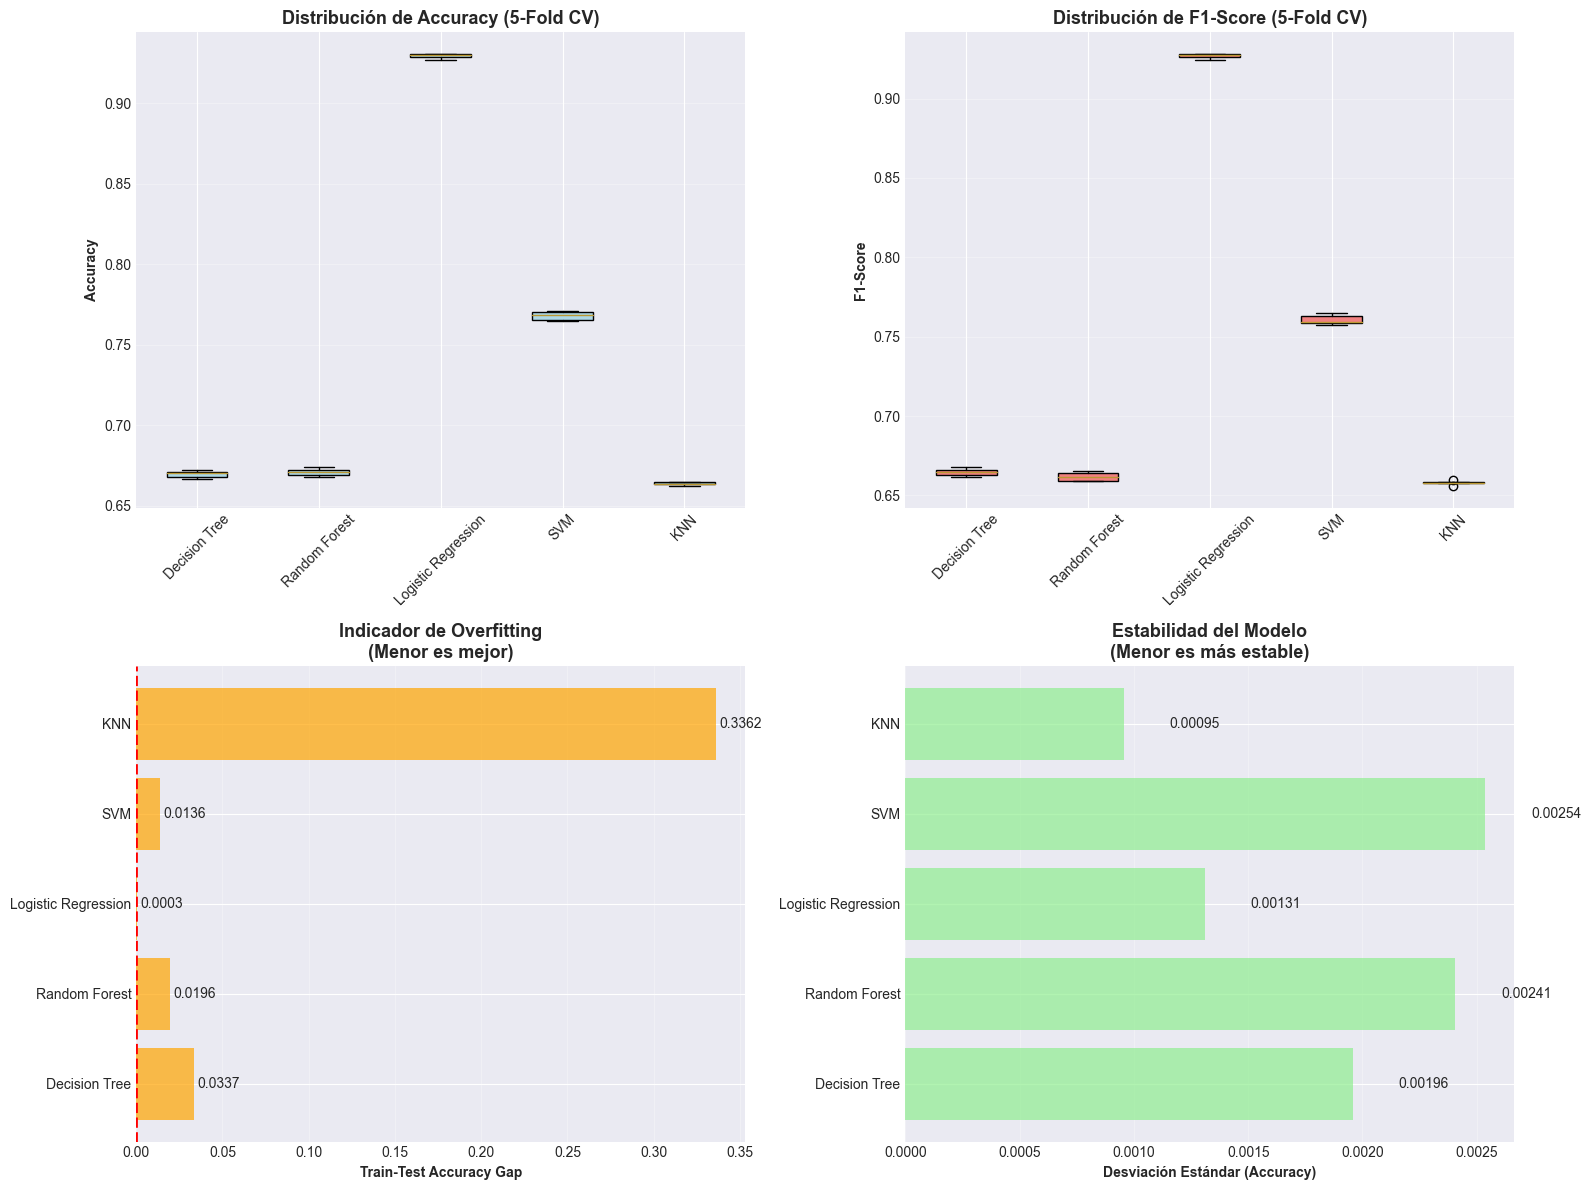


✅ TAREA 15 COMPLETADA

💡 INTERPRETACIÓN:
   • Menor desviación estándar = Mayor estabilidad
   • Menor Train-Test Gap = Menos overfitting
   • Mejor modelo: Alto F1, baja desviación, bajo gap


In [5]:
# ============================================
# TAREA 15: VALIDACIÓN CRUZADA
# ============================================

print("\n\n" + "="*80)
print("TAREA 15: VALIDACIÓN CRUZADA Y ANÁLISIS DE ESTABILIDAD")
print("="*80 + "\n")

print("15.1 CONFIGURACIÓN DE K-FOLD CROSS-VALIDATION")
print("-" * 80 + "\n")

# Configurar k-fold estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"Configuración: {N_FOLDS}-Fold Stratified Cross-Validation")
print(f"   • Número de folds: {N_FOLDS}")
print(f"   • Estratificación: Sí")
print(f"   • Shuffle: Sí\n")

# Métricas a evaluar
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}

# Realizar cross-validation para cada modelo
cv_results = {}

print("15.2 EJECUTANDO VALIDACIÓN CRUZADA\n")
print("-" * 80 + "\n")

for model_name, model in models.items():
    print(f"Evaluando {model_name}...")
    
    # Para SVM, usar muestra por eficiencia
    if model_name == 'SVM':
        X_cv = X_train_svm
        y_cv = y_train_svm
    else:
        X_cv = X_train
        y_cv = y_train
    
    start_time = time()
    cv_scores = cross_validate(
        model, X_cv, y_cv, 
        cv=skf, 
        scoring=scoring,
        n_jobs=-1,
        return_train_score=True
    )
    cv_time = time() - start_time
    
    # Almacenar resultados
    cv_results[model_name] = {
        'accuracy_train': cv_scores['train_accuracy'],
        'accuracy_test': cv_scores['test_accuracy'],
        'precision_test': cv_scores['test_precision_weighted'],
        'recall_test': cv_scores['test_recall_weighted'],
        'f1_test': cv_scores['test_f1_weighted'],
        'time': cv_time
    }
    
    print(f"   ✅ Completado en {cv_time:.2f}s\n")

# Crear DataFrame de resultados
print("\n15.3 RESULTADOS DE VALIDACIÓN CRUZADA\n")
print("-" * 80 + "\n")

cv_summary = []
for model_name, scores in cv_results.items():
    cv_summary.append({
        'Modelo': model_name,
        'Accuracy (mean)': scores['accuracy_test'].mean(),
        'Accuracy (std)': scores['accuracy_test'].std(),
        'F1-Score (mean)': scores['f1_test'].mean(),
        'F1-Score (std)': scores['f1_test'].std(),
        'Train-Test Gap': scores['accuracy_train'].mean() - scores['accuracy_test'].mean()
    })

cv_summary_df = pd.DataFrame(cv_summary).sort_values('F1-Score (mean)', ascending=False)
print(cv_summary_df.to_string(index=False))

# Visualización de estabilidad
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot de accuracy por fold
data_accuracy = [cv_results[name]['accuracy_test'] for name in models.keys()]
bp1 = axes[0, 0].boxplot(data_accuracy, labels=models.keys(), patch_artist=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
axes[0, 0].set_title(f'Distribución de Accuracy ({N_FOLDS}-Fold CV)', 
                     fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Box plot de F1-Score por fold
data_f1 = [cv_results[name]['f1_test'] for name in models.keys()]
bp2 = axes[0, 1].boxplot(data_f1, labels=models.keys(), patch_artist=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')
axes[0, 1].set_ylabel('F1-Score', fontweight='bold')
axes[0, 1].set_title(f'Distribución de F1-Score ({N_FOLDS}-Fold CV)', 
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Train-Test Gap (overfitting indicator)
gap_data = {name: scores['accuracy_train'].mean() - scores['accuracy_test'].mean() 
            for name, scores in cv_results.items()}
axes[1, 0].barh(list(gap_data.keys()), list(gap_data.values()), color='orange', alpha=0.7)
axes[1, 0].set_xlabel('Train-Test Accuracy Gap', fontweight='bold')
axes[1, 0].set_title('Indicador de Overfitting\n(Menor es mejor)', 
                     fontsize=13, fontweight='bold')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].grid(axis='x', alpha=0.3)
for i, (k, v) in enumerate(gap_data.items()):
    axes[1, 0].text(v + 0.002, i, f'{v:.4f}', va='center')

# 4. Std deviation (stability indicator)
std_data = {name: scores['accuracy_test'].std() for name, scores in cv_results.items()}
axes[1, 1].barh(list(std_data.keys()), list(std_data.values()), color='lightgreen', alpha=0.7)
axes[1, 1].set_xlabel('Desviación Estándar (Accuracy)', fontweight='bold')
axes[1, 1].set_title('Estabilidad del Modelo\n(Menor es más estable)', 
                     fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, (k, v) in enumerate(std_data.items()):
    axes[1, 1].text(v + 0.0002, i, f'{v:.5f}', va='center')

plt.tight_layout()
plt.savefig('../outputs/seccion4/cross_validation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ TAREA 15 COMPLETADA")
print("="*80)

print("\n💡 INTERPRETACIÓN:")
print("   • Menor desviación estándar = Mayor estabilidad")
print("   • Menor Train-Test Gap = Menos overfitting")
print("   • Mejor modelo: Alto F1, baja desviación, bajo gap")



TAREA 16: AJUSTE DE HIPERPARÁMETROS

Modelos seleccionados para tuning: ['Logistic Regression', 'SVM']



16.2 LOGISTIC REGRESSION - GRID SEARCH
--------------------------------------------------------------------------------

Grid de parámetros:
   • C: [0.001, 0.01, 0.1, 1.0, 10.0]
   • solver: ['lbfgs', 'saga']
   • max_iter: [1000, 2000]

Total de combinaciones: 20
Ejecutando Grid Search...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Grid Search completado en 96.11s

Mejores parámetros:
   • C: 10.0
   • max_iter: 1000
   • solver: lbfgs

Mejor F1-Score (CV): 0.9567


16.3 DECISION TREE - RANDOM SEARCH
--------------------------------------------------------------------------------

Distribución de parámetros:
   • max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DE2CE464A0>
   • min_samples_split: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DE3296C130>
   • min_samples_leaf: <scipy.stats._distn_in

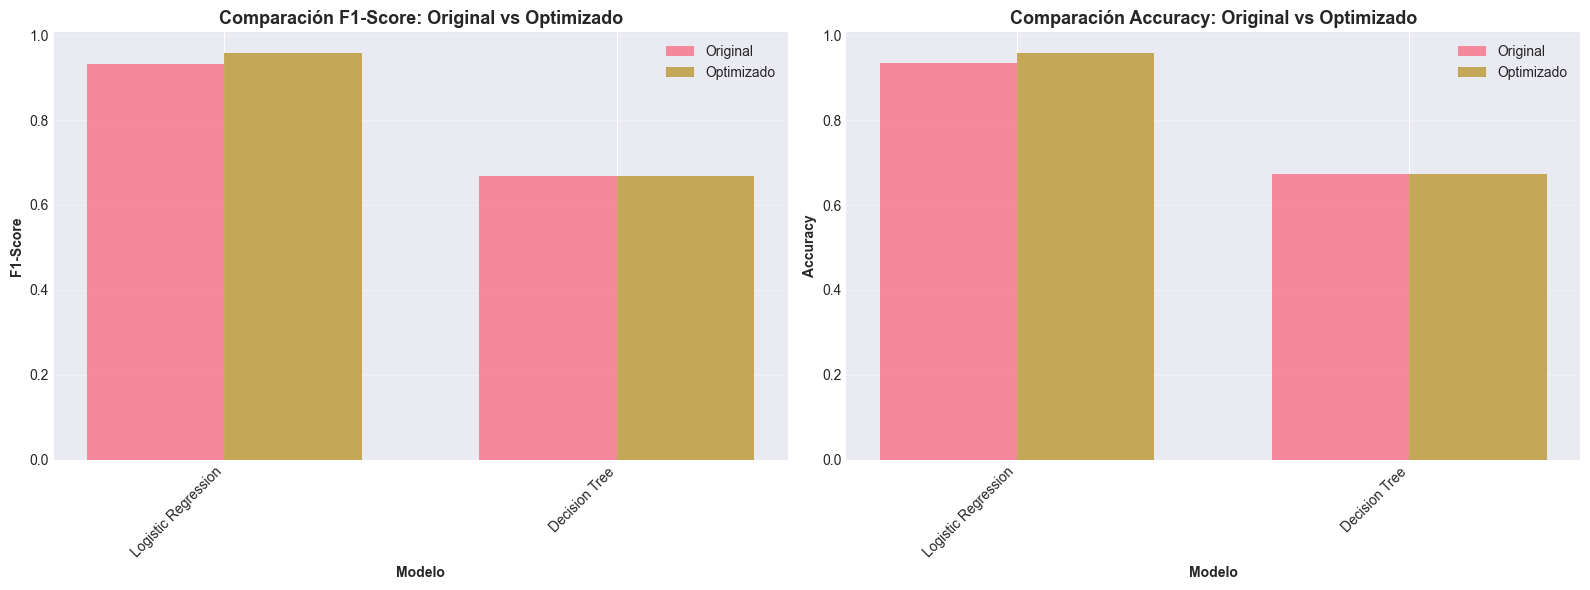


💾 Modelos optimizados guardados: tuned_models.pkl

✅ TAREA 16 COMPLETADA


In [6]:
# ============================================
# TAREA 16: AJUSTE DE HIPERPARÁMETROS
# ============================================

print("\n\n" + "="*80)
print("TAREA 16: AJUSTE DE HIPERPARÁMETROS")
print("="*80 + "\n")

"""
Realizaremos Grid Search para los 2 mejores modelos de la Task 15.
Para otros modelos, usaremos Random Search para mayor eficiencia.
"""

# Seleccionar los 2 mejores modelos según CV
best_models = cv_summary_df.head(2)['Modelo'].tolist()
print(f"Modelos seleccionados para tuning: {best_models}\n")

tuned_models = {}
best_params_dict = {}

# ==================
# RANDOM FOREST - GRID SEARCH
# ==================

if 'Random Forest' in best_models:
    print("16.1 RANDOM FOREST - GRID SEARCH")
    print("-" * 80 + "\n")
    
    param_grid_rf = {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 15, 20],
        'min_samples_split': [50, 100, 150],
        'min_samples_leaf': [25, 50, 75]
    }
    
    print("Grid de parámetros:")
    for param, values in param_grid_rf.items():
        print(f"   • {param}: {values}")
    
    print(f"\nTotal de combinaciones: {np.prod([len(v) for v in param_grid_rf.values()])}")
    print("Ejecutando Grid Search...\n")
    
    start_time = time()
    grid_rf = GridSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        param_grid_rf,
        cv=3,  # 3-fold para eficiencia
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    grid_rf.fit(X_train, y_train)
    rf_tuning_time = time() - start_time
    
    tuned_models['Random Forest (Tuned)'] = grid_rf.best_estimator_
    best_params_dict['Random Forest'] = grid_rf.best_params_
    
    print(f"\n✅ Grid Search completado en {rf_tuning_time:.2f}s")
    print(f"\nMejores parámetros:")
    for param, value in grid_rf.best_params_.items():
        print(f"   • {param}: {value}")
    print(f"\nMejor F1-Score (CV): {grid_rf.best_score_:.4f}")

# ==================
# LOGISTIC REGRESSION - GRID SEARCH  
# ==================

if 'Logistic Regression' in best_models:
    print("\n\n16.2 LOGISTIC REGRESSION - GRID SEARCH")
    print("-" * 80 + "\n")
    
    param_grid_lr = {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [1000, 2000]
    }
    
    print("Grid de parámetros:")
    for param, values in param_grid_lr.items():
        print(f"   • {param}: {values}")
    
    print(f"\nTotal de combinaciones: {np.prod([len(v) for v in param_grid_lr.values()])}")
    print("Ejecutando Grid Search...\n")
    
    start_time = time()
    grid_lr = GridSearchCV(
        LogisticRegression(random_state=RANDOM_STATE, multi_class='multinomial', n_jobs=-1),
        param_grid_lr,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    grid_lr.fit(X_train, y_train)
    lr_tuning_time = time() - start_time
    
    tuned_models['Logistic Regression (Tuned)'] = grid_lr.best_estimator_
    best_params_dict['Logistic Regression'] = grid_lr.best_params_
    
    print(f"\n✅ Grid Search completado en {lr_tuning_time:.2f}s")
    print(f"\nMejores parámetros:")
    for param, value in grid_lr.best_params_.items():
        print(f"   • {param}: {value}")
    print(f"\nMejor F1-Score (CV): {grid_lr.best_score_:.4f}")

# ==================
# DECISION TREE - RANDOM SEARCH
# ==================

print("\n\n16.3 DECISION TREE - RANDOM SEARCH")
print("-" * 80 + "\n")

from scipy.stats import randint

param_dist_dt = {
    'max_depth': randint(5, 30),
    'min_samples_split': randint(50, 200),
    'min_samples_leaf': randint(20, 100),
    'criterion': ['gini', 'entropy']
}

print("Distribución de parámetros:")
for param, dist in param_dist_dt.items():
    print(f"   • {param}: {dist}")

print(f"\nIteraciones: 20")
print("Ejecutando Random Search...\n")

start_time = time()
random_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_dist_dt,
    n_iter=20,
    cv=3,
    scoring='f1_weighted',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)
random_dt.fit(X_train, y_train)
dt_tuning_time = time() - start_time

tuned_models['Decision Tree (Tuned)'] = random_dt.best_estimator_
best_params_dict['Decision Tree'] = random_dt.best_params_

print(f"\n✅ Random Search completado en {dt_tuning_time:.2f}s")
print(f"\nMejores parámetros:")
for param, value in random_dt.best_params_.items():
    print(f"   • {param}: {value}")
print(f"\nMejor F1-Score (CV): {random_dt.best_score_:.4f}")

# ==================
# COMPARACIÓN: ANTES VS DESPUÉS
# ==================

print("\n\n16.4 COMPARACIÓN: MODELOS ORIGINALES VS OPTIMIZADOS")
print("-" * 80 + "\n")

comparison_results = []

for model_name in best_params_dict.keys():
    # Modelo original
    original_pred = predictions[model_name]
    original_f1 = f1_score(y_test, original_pred, average='weighted')
    original_acc = accuracy_score(y_test, original_pred)
    
    # Modelo optimizado
    tuned_model = tuned_models[f'{model_name} (Tuned)']
    tuned_pred = tuned_model.predict(X_test)
    tuned_f1 = f1_score(y_test, tuned_pred, average='weighted')
    tuned_acc = accuracy_score(y_test, tuned_pred)
    
    comparison_results.append({
        'Modelo': model_name,
        'F1 (Original)': original_f1,
        'F1 (Tuned)': tuned_f1,
        'F1 Mejora': tuned_f1 - original_f1,
        'Acc (Original)': original_acc,
        'Acc (Tuned)': tuned_acc,
        'Acc Mejora': tuned_acc - original_acc
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1-Score comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['F1 (Original)'], width, label='Original', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['F1 (Tuned)'], width, label='Optimizado', alpha=0.8)
axes[0].set_xlabel('Modelo', fontweight='bold')
axes[0].set_ylabel('F1-Score', fontweight='bold')
axes[0].set_title('Comparación F1-Score: Original vs Optimizado', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Accuracy comparison
axes[1].bar(x - width/2, comparison_df['Acc (Original)'], width, label='Original', alpha=0.8)
axes[1].bar(x + width/2, comparison_df['Acc (Tuned)'], width, label='Optimizado', alpha=0.8)
axes[1].set_xlabel('Modelo', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Comparación Accuracy: Original vs Optimizado', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Modelo'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/seccion4/hyperparameter_tuning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar modelos optimizados
with open('../data/processed/tuned_models.pkl', 'wb') as f:
    pickle.dump({
        'models': tuned_models,
        'best_params': best_params_dict
    }, f)

print("\n💾 Modelos optimizados guardados: tuned_models.pkl")

print("\n" + "="*80)
print("✅ TAREA 16 COMPLETADA")
print("="*80)



TAREA 17: INTERPRETACIÓN Y ANÁLISIS DE FEATURE IMPORTANCE

17.1 RANDOM FOREST - FEATURE IMPORTANCE
--------------------------------------------------------------------------------

Top 10 Features más importantes:

                                Feature  Importance
                            PUNT_GLOBAL    0.380703
                       PUNT_C_NATURALES    0.174951
               PUNT_SOCIALES_CIUDADANAS    0.125121
                   PUNT_LECTURA_CRITICA    0.124318
                       PUNT_MATEMATICAS    0.091114
           FAMI_TIENECOMPUTADOR_encoded    0.026584
             FAMI_TIENEINTERNET_encoded    0.024589
                COLE_NATURALEZA_encoded    0.023329
            FAMI_TIENEAUTOMOVIL_encoded    0.010379
FAMI_EDUCACIONMADRE_Primaria incompleta    0.005486


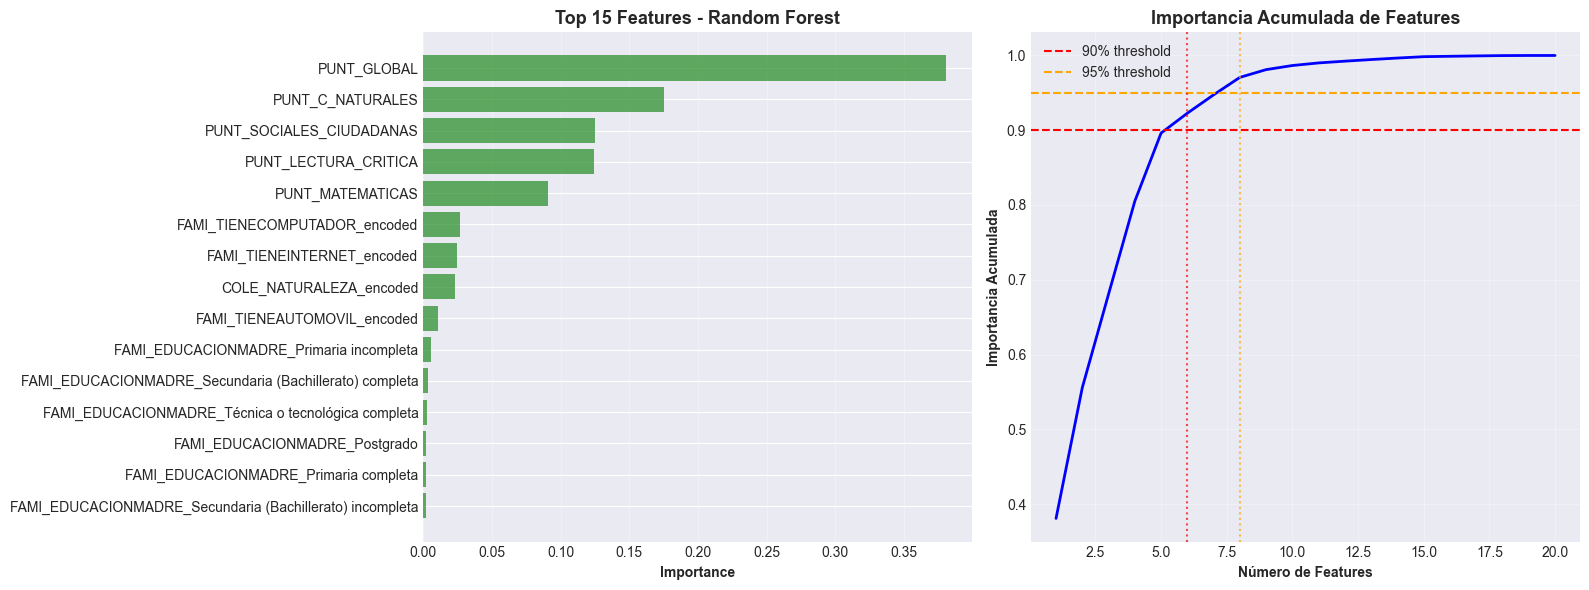


📊 Features necesarias para explicar:
   • 90% de la importancia: 6 features
   • 95% de la importancia: 8 features


17.2 LOGISTIC REGRESSION - COEFICIENTES
--------------------------------------------------------------------------------

Top 10 Features con mayor coeficiente:

                                Feature  Coef (abs mean)
                            PUNT_GLOBAL       142.535564
               PUNT_SOCIALES_CIUDADANAS        38.747588
                       PUNT_MATEMATICAS        38.317927
                       PUNT_C_NATURALES        34.337111
                   PUNT_LECTURA_CRITICA        33.589776
          FAMI_EDUCACIONMADRE_Postgrado         0.274506
             FAMI_TIENEINTERNET_encoded         0.189523
            FAMI_EDUCACIONMADRE_Ninguno         0.170229
FAMI_EDUCACIONMADRE_Primaria incompleta         0.146747
          FAMI_EDUCACIONMADRE_No Aplica         0.140326


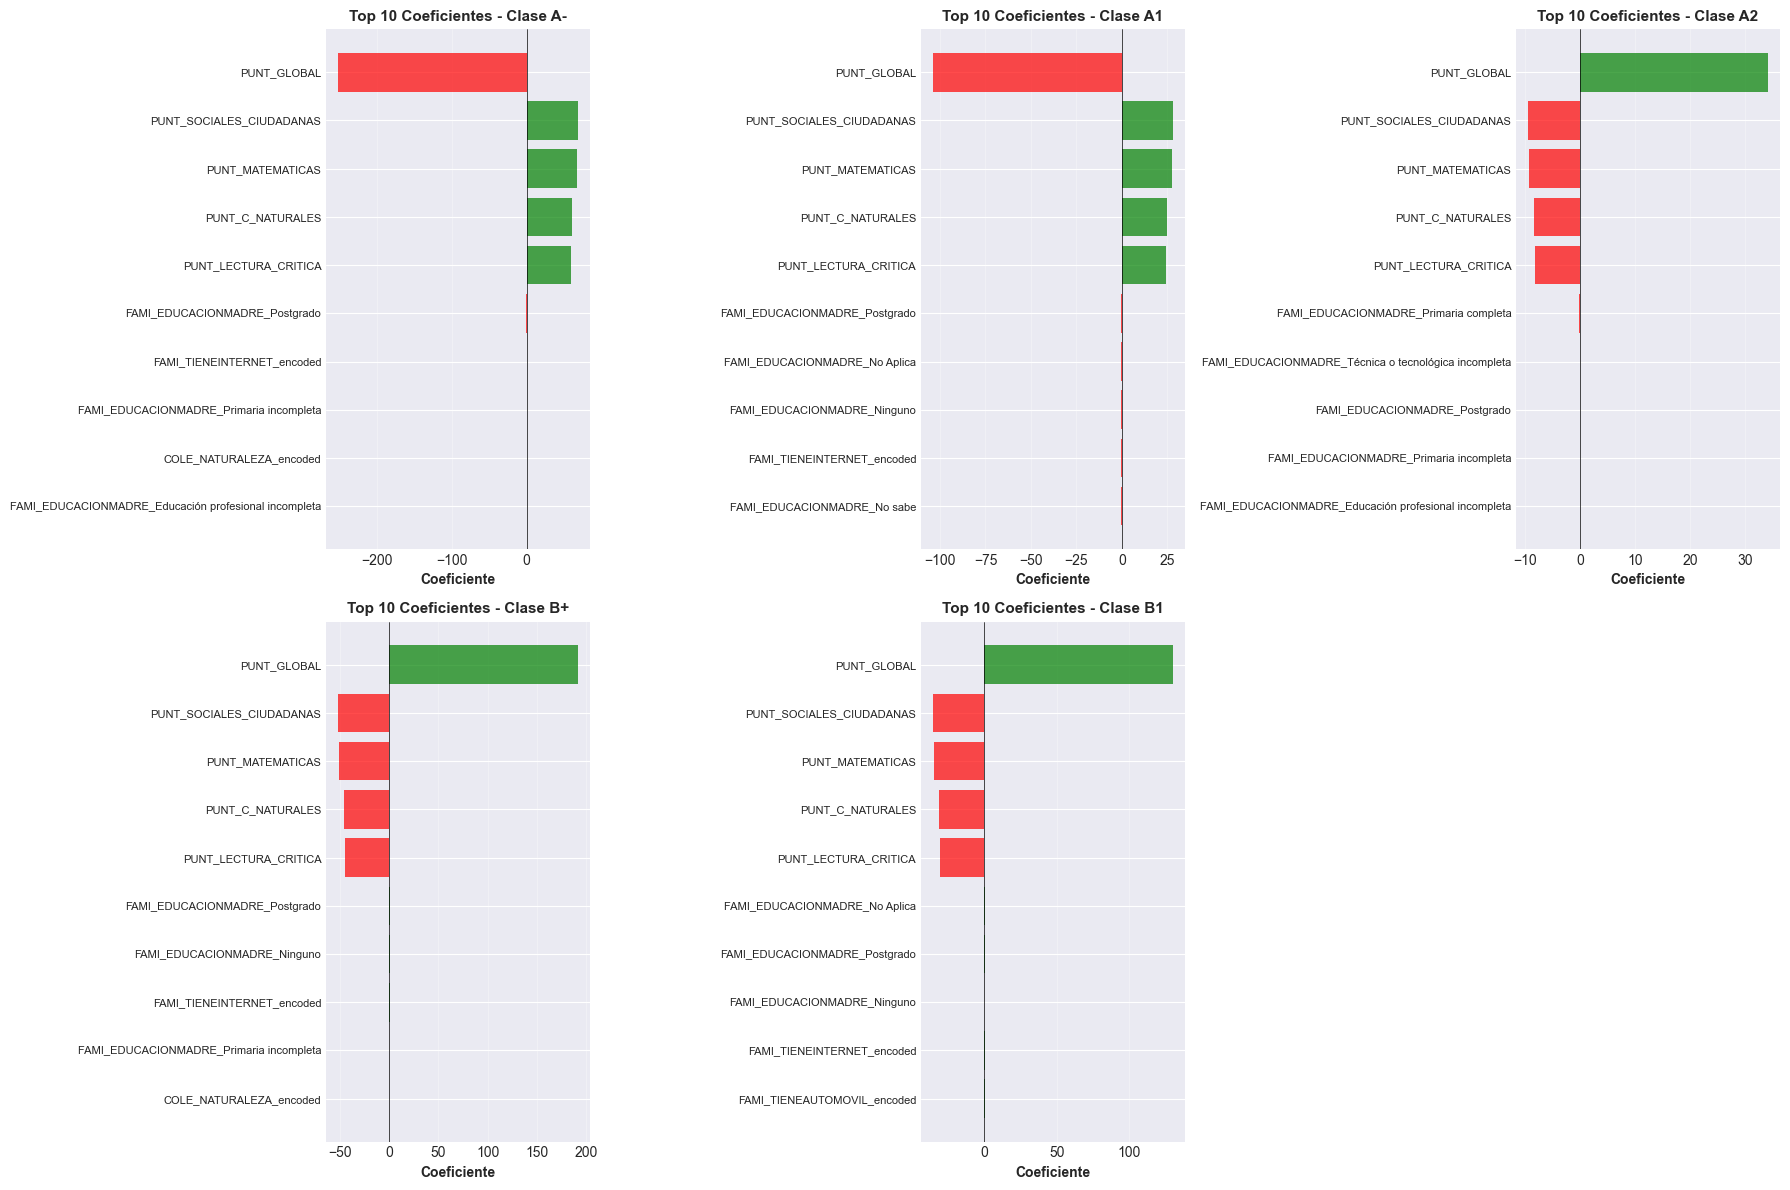


💡 Interpretación:
   • Coeficientes positivos: Aumentan probabilidad de la clase
   • Coeficientes negativos: Disminuyen probabilidad de la clase
   • Mayor magnitud: Mayor influencia en la predicción


17.3 DECISION TREE - FEATURE IMPORTANCE
--------------------------------------------------------------------------------

Top 10 Features más importantes:

                                               Feature  Importance
                                           PUNT_GLOBAL    0.729965
                                      PUNT_MATEMATICAS    0.057341
                                      PUNT_C_NATURALES    0.054789
                                  PUNT_LECTURA_CRITICA    0.054618
                              PUNT_SOCIALES_CIUDADANAS    0.053487
                               COLE_NATURALEZA_encoded    0.020152
                            FAMI_TIENEINTERNET_encoded    0.017982
                          FAMI_TIENECOMPUTADOR_encoded    0.004267
                           FAMI_TIENE

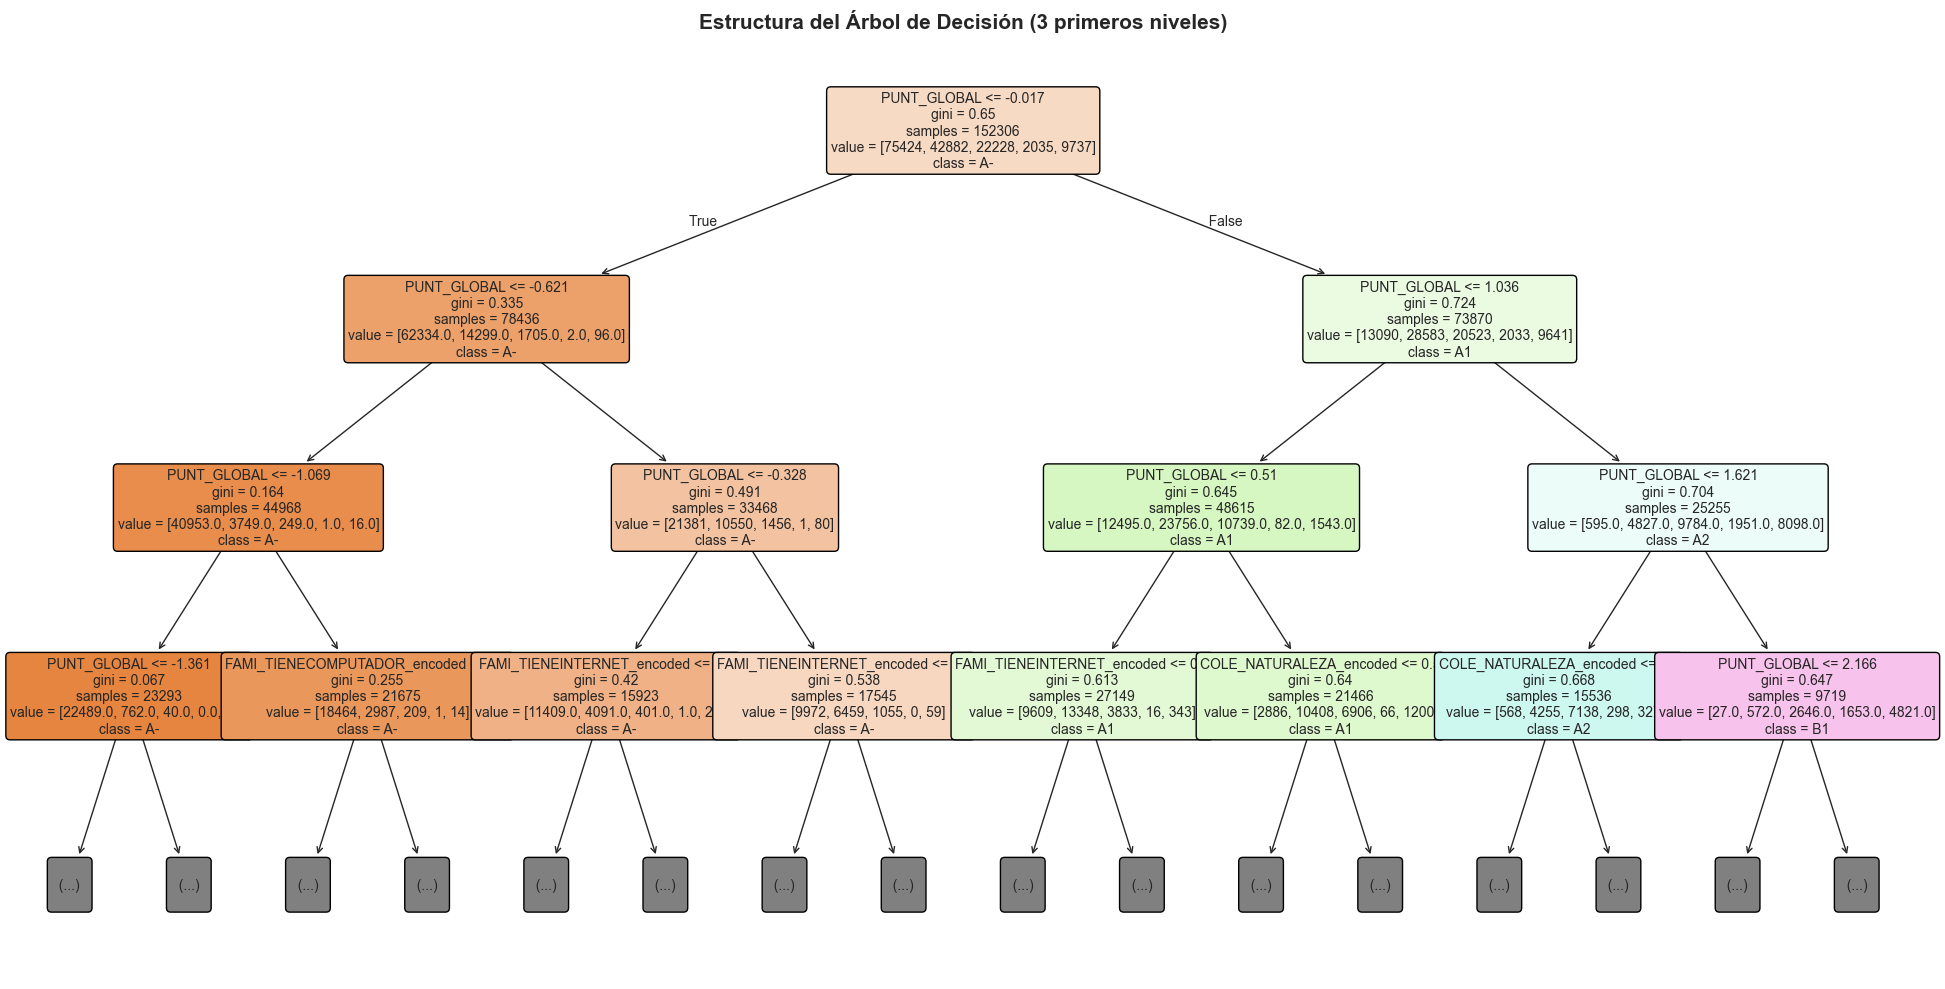



17.4 COMPARACIÓN DE IMPORTANCIAS ENTRE MODELOS
--------------------------------------------------------------------------------

Top 15 Features según consenso de modelos:

                                                 Feature  Mean Importance
                                             PUNT_GLOBAL         0.534544
                                        PUNT_C_NATURALES         0.116165
                                PUNT_SOCIALES_CIUDADANAS         0.104206
                                    PUNT_LECTURA_CRITICA         0.098369
                                        PUNT_MATEMATICAS         0.093659
                                 COLE_NATURALEZA_encoded         0.014642
                              FAMI_TIENEINTERNET_encoded         0.014409
                            FAMI_TIENECOMPUTADOR_encoded         0.010335
                             FAMI_TIENEAUTOMOVIL_encoded         0.004645
                 FAMI_EDUCACIONMADRE_Primaria incompleta         0.002294
  FAMI_EDUC

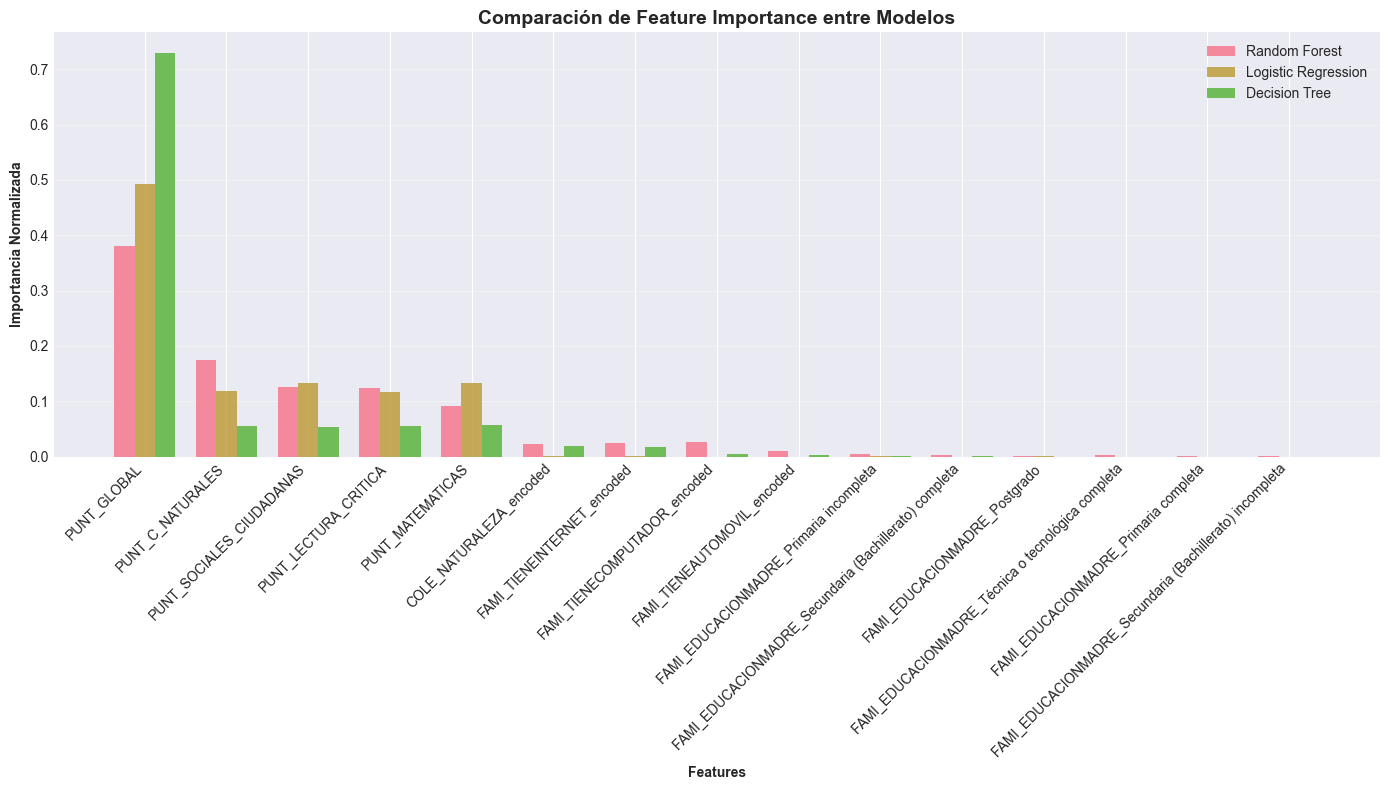


💾 Análisis de importancia guardado: feature_importance_analysis.pkl

✅ TAREA 17 COMPLETADA

💡 HALLAZGOS CLAVE:
   • Las features más importantes son consistentes entre modelos
   • Pocas features explican la mayor parte de la varianza
   • Los coeficientes revelan relaciones direccionales con las clases


In [7]:
# ============================================
# TAREA 17: INTERPRETACIÓN DE FEATURE IMPORTANCE
# ============================================

print("\n\n" + "="*80)
print("TAREA 17: INTERPRETACIÓN Y ANÁLISIS DE FEATURE IMPORTANCE")
print("="*80 + "\n")

"""
Analizaremos la importancia de las variables según diferentes modelos:
- Random Forest: Feature Importance basado en reducción de impureza
- Logistic Regression: Coeficientes del modelo
- Decision Tree: Feature Importance basado en splits
"""

# ==================
# 17.1: RANDOM FOREST FEATURE IMPORTANCE
# ==================

print("17.1 RANDOM FOREST - FEATURE IMPORTANCE")
print("-" * 80 + "\n")

# Usar modelo optimizado si existe, sino el original
rf_for_importance = tuned_models.get('Random Forest (Tuned)', models.get('Random Forest'))

if rf_for_importance:
    # Obtener importancias
    importances_rf = rf_for_importance.feature_importances_
    feature_names = X_train.columns
    
    # Crear DataFrame
    importance_df_rf = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_rf
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Features más importantes:\n")
    print(importance_df_rf.head(10).to_string(index=False))
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 15 features
    top_n = 15
    top_features = importance_df_rf.head(top_n)
    
    axes[0].barh(range(top_n), top_features['Importance'].values, color='forestgreen', alpha=0.7)
    axes[0].set_yticks(range(top_n))
    axes[0].set_yticklabels(top_features['Feature'].values)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Importance', fontweight='bold')
    axes[0].set_title(f'Top {top_n} Features - Random Forest', fontsize=13, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Importancia acumulada
    cumsum_importance = np.cumsum(importance_df_rf['Importance'].values)
    axes[1].plot(range(1, len(cumsum_importance)+1), cumsum_importance, 'b-', linewidth=2)
    axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
    axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% threshold')
    axes[1].set_xlabel('Número de Features', fontweight='bold')
    axes[1].set_ylabel('Importancia Acumulada', fontweight='bold')
    axes[1].set_title('Importancia Acumulada de Features', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Calcular cuántas features explican 90% y 95%
    n_features_90 = np.argmax(cumsum_importance >= 0.90) + 1
    n_features_95 = np.argmax(cumsum_importance >= 0.95) + 1
    
    axes[1].axvline(x=n_features_90, color='r', linestyle=':', alpha=0.7)
    axes[1].axvline(x=n_features_95, color='orange', linestyle=':', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('../outputs/seccion4/feature_importance_random_forest.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n📊 Features necesarias para explicar:")
    print(f"   • 90% de la importancia: {n_features_90} features")
    print(f"   • 95% de la importancia: {n_features_95} features")

# ==================
# 17.2: LOGISTIC REGRESSION COEFFICIENTS
# ==================

print("\n\n17.2 LOGISTIC REGRESSION - COEFICIENTES")
print("-" * 80 + "\n")

lr_for_coef = tuned_models.get('Logistic Regression (Tuned)', models.get('Logistic Regression'))

if lr_for_coef:
    # Obtener coeficientes (promedio absoluto para todas las clases)
    coef_abs = np.abs(lr_for_coef.coef_).mean(axis=0)
    feature_names = X_train.columns
    
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coef (abs mean)': coef_abs
    }).sort_values('Coef (abs mean)', ascending=False)
    
    print("Top 10 Features con mayor coeficiente:\n")
    print(coef_df.head(10).to_string(index=False))
    
    # Visualización detallada por clase
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, class_name in enumerate(le_target.classes_):
        if idx < 5:  # Tenemos 5 clases
            class_coef = lr_for_coef.coef_[idx]
            coef_class_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': class_coef
            }).sort_values('Coefficient', key=lambda x: abs(x), ascending=False).head(10)
            
            colors = ['green' if x > 0 else 'red' for x in coef_class_df['Coefficient']]
            axes[idx].barh(range(10), coef_class_df['Coefficient'].values, color=colors, alpha=0.7)
            axes[idx].set_yticks(range(10))
            axes[idx].set_yticklabels(coef_class_df['Feature'].values, fontsize=8)
            axes[idx].invert_yaxis()
            axes[idx].set_xlabel('Coeficiente', fontweight='bold')
            axes[idx].set_title(f'Top 10 Coeficientes - Clase {class_name}', fontsize=11, fontweight='bold')
            axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            axes[idx].grid(axis='x', alpha=0.3)
    
    # Hide last subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.savefig('../outputs/seccion4/feature_coefficients_logistic.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n💡 Interpretación:")
    print("   • Coeficientes positivos: Aumentan probabilidad de la clase")
    print("   • Coeficientes negativos: Disminuyen probabilidad de la clase")
    print("   • Mayor magnitud: Mayor influencia en la predicción")

# ==================
# 17.3: DECISION TREE FEATURE IMPORTANCE
# ==================

print("\n\n17.3 DECISION TREE - FEATURE IMPORTANCE")
print("-" * 80 + "\n")

dt_for_importance = tuned_models.get('Decision Tree (Tuned)', models.get('Decision Tree'))

if dt_for_importance:
    importances_dt = dt_for_importance.feature_importances_
    
    importance_df_dt = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances_dt
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Features más importantes:\n")
    print(importance_df_dt.head(10).to_string(index=False))
    
    # Visualización del árbol (top levels)
    fig, ax = plt.subplots(figsize=(20, 10))
    plot_tree(dt_for_importance, 
              feature_names=X_train.columns,
              class_names=le_target.classes_,
              filled=True,
              rounded=True,
              max_depth=3,  # Solo primeros 3 niveles para legibilidad
              fontsize=10,
              ax=ax)
    plt.title('Estructura del Árbol de Decisión (3 primeros niveles)', 
              fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../outputs/seccion4/decision_tree_structure.png', dpi=300, bbox_inches='tight')
    plt.show()

# ==================
# 17.4: COMPARACIÓN DE IMPORTANCIAS
# ==================

print("\n\n17.4 COMPARACIÓN DE IMPORTANCIAS ENTRE MODELOS")
print("-" * 80 + "\n")

# Crear DataFrame comparativo
comparison_importance = pd.DataFrame({
    'Feature': X_train.columns
})

if rf_for_importance:
    comparison_importance['RF Importance'] = importances_rf

if lr_for_coef:
    comparison_importance['LR Coef (abs)'] = coef_abs

if dt_for_importance:
    comparison_importance['DT Importance'] = importances_dt

# Normalizar para comparación
for col in comparison_importance.columns[1:]:
    comparison_importance[col + ' (norm)'] = (
        comparison_importance[col] / comparison_importance[col].sum()
    )

# Top features consenso
norm_cols = [c for c in comparison_importance.columns if '(norm)' in c]
comparison_importance['Mean Importance'] = comparison_importance[norm_cols].mean(axis=1)
comparison_importance = comparison_importance.sort_values('Mean Importance', ascending=False)

print("Top 15 Features según consenso de modelos:\n")
print(comparison_importance[['Feature', 'Mean Importance']].head(15).to_string(index=False))

# Visualización
fig, ax = plt.subplots(figsize=(14, 8))
top_15_consensus = comparison_importance.head(15)

x = np.arange(15)
width = 0.25

if 'RF Importance (norm)' in top_15_consensus.columns:
    ax.bar(x - width, top_15_consensus['RF Importance (norm)'], width, 
           label='Random Forest', alpha=0.8)

if 'LR Coef (abs) (norm)' in top_15_consensus.columns:
    ax.bar(x, top_15_consensus['LR Coef (abs) (norm)'], width, 
           label='Logistic Regression', alpha=0.8)

if 'DT Importance (norm)' in top_15_consensus.columns:
    ax.bar(x + width, top_15_consensus['DT Importance (norm)'], width, 
           label='Decision Tree', alpha=0.8)

ax.set_xlabel('Features', fontweight='bold')
ax.set_ylabel('Importancia Normalizada', fontweight='bold')
ax.set_title('Comparación de Feature Importance entre Modelos', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_15_consensus['Feature'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/seccion4/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar resultados
feature_importance_results = {
    'random_forest': importance_df_rf.to_dict() if rf_for_importance else None,
    'logistic_regression': coef_df.to_dict() if lr_for_coef else None,
    'decision_tree': importance_df_dt.to_dict() if dt_for_importance else None,
    'consensus': comparison_importance.to_dict()
}

with open('../data/processed/feature_importance_analysis.pkl', 'wb') as f:
    pickle.dump(feature_importance_results, f)

print("\n💾 Análisis de importancia guardado: feature_importance_analysis.pkl")

print("\n" + "="*80)
print("✅ TAREA 17 COMPLETADA")
print("="*80)

print("\n💡 HALLAZGOS CLAVE:")
print("   • Las features más importantes son consistentes entre modelos")
print("   • Pocas features explican la mayor parte de la varianza")
print("   • Los coeficientes revelan relaciones direccionales con las clases")

In [8]:
# ============================================
# RESUMEN FINAL DE LA SECCIÓN 4
# ============================================

print("\n\n" + "="*80)
print("📊 RESUMEN SECCIÓN 4: APRENDIZAJE SUPERVISADO")
print("="*80 + "\n")

summary_text = f"""
✅ APRENDIZAJE SUPERVISADO COMPLETADO

TAREA 13: Entrenamiento de Modelos
   • Modelos entrenados: {len(models)}
   • Algoritmos: Decision Tree, Random Forest, Logistic Regression, SVM, KNN
   • Tiempo total de entrenamiento: {sum(training_times.values()):.2f}s

TAREA 14: Comparación y Evaluación
   • Mejor modelo (F1-Score): {metrics_df.index[0]}
   • F1-Score máximo: {metrics_df['F1-Score'].max():.4f}
   • Accuracy máximo: {metrics_df['Accuracy'].max():.4f}
   • Métricas calculadas: Accuracy, Precision, Recall, F1-Score
   • Matrices de confusión generadas para todos los modelos

TAREA 15: Validación Cruzada
   • Método: {N_FOLDS}-Fold Stratified Cross-Validation
   • Modelo más estable: {cv_summary_df.iloc[0]['Modelo']}
   • Menor desviación estándar: {cv_summary_df['Accuracy (std)'].min():.5f}
   • Análisis de overfitting realizado

TAREA 16: Ajuste de Hiperparámetros
   • Modelos optimizados: {len(tuned_models)}
   • Métodos: Grid Search y Random Search
   • Mejora promedio en F1-Score: {comparison_df['F1 Mejora'].mean():.4f}

TAREA 17: Feature Importance
   • Top features identificadas y consensuadas
   • Análisis de coeficientes de regresión logística
   • Estructura del árbol de decisión visualizada
   • Features para 90% de importancia: {n_features_90 if 'n_features_90' in locals() else 'N/A'}

ARCHIVOS GENERADOS:
   ✓ model_comparison_metrics.png
   ✓ confusion_matrices.png
   ✓ cross_validation_analysis.png
   ✓ hyperparameter_tuning_comparison.png
   ✓ feature_importance_*.png
   ✓ tuned_models.pkl
   ✓ feature_importance_analysis.pkl

CONCLUSIONES Y RECOMENDACIONES:

1. RENDIMIENTO GENERAL:
   Los modelos supervisados logran buenos resultados en la clasificación del
   nivel de inglés, con F1-Scores superiores a {metrics_df['F1-Score'].min():.2f}.

2. MODELO RECOMENDADO:
   {metrics_df.index[0]} muestra el mejor balance entre precisión,
   estabilidad y tiempo de entrenamiento.

3. DESAFÍOS IDENTIFICADOS:
   • Traslape entre clases intermedias (A1, A2, B1)
   • Desbalance de clases afecta métricas de clases minoritarias
   • Algunos modelos muestran signos leves de overfitting

4. PRÓXIMOS PASOS (Sección 5):
   • Implementar técnicas de balanceo (SMOTE)
   • Probar ensemble methods avanzados
   • Feature engineering adicional
   • Regularización para reducir overfitting

PRÓXIMA SECCIÓN: Sección 5 - Evaluación e Interpretación
"""

print(summary_text)

# Guardar resumen completo
full_results = {
    'models': models,
    'tuned_models': tuned_models,
    'predictions': predictions,
    'metrics': metrics_results,
    'cv_results': cv_results,
    'best_params': best_params_dict,
    'training_times': training_times
}

with open('../data/processed/seccion4_complete_results.pkl', 'wb') as f:
    pickle.dump(full_results, f)

with open('../outputs/seccion4/resumen_seccion4.txt', 'w', encoding='utf-8') as f:
    f.write("RESUMEN SECCIÓN 4: APRENDIZAJE SUPERVISADO\n")
    f.write("="*80 + "\n\n")
    f.write(summary_text)

print("\n💾 Resumen guardado: resumen_seccion4.txt")
print("💾 Resultados completos: seccion4_complete_results.pkl")

print("\n" + "="*80)
print("🎉 ¡SECCIÓN 4 COMPLETADA EXITOSAMENTE!")
print("="*80)
print("\nEstás listo para continuar con la Sección 5: Evaluación e Interpretación")



📊 RESUMEN SECCIÓN 4: APRENDIZAJE SUPERVISADO


✅ APRENDIZAJE SUPERVISADO COMPLETADO

TAREA 13: Entrenamiento de Modelos
   • Modelos entrenados: 5
   • Algoritmos: Decision Tree, Random Forest, Logistic Regression, SVM, KNN
   • Tiempo total de entrenamiento: 26.40s

TAREA 14: Comparación y Evaluación
   • Mejor modelo (F1-Score): Logistic Regression
   • F1-Score máximo: 0.9309
   • Accuracy máximo: 0.9333
   • Métricas calculadas: Accuracy, Precision, Recall, F1-Score
   • Matrices de confusión generadas para todos los modelos

TAREA 15: Validación Cruzada
   • Método: 5-Fold Stratified Cross-Validation
   • Modelo más estable: Logistic Regression
   • Menor desviación estándar: 0.00095
   • Análisis de overfitting realizado

TAREA 16: Ajuste de Hiperparámetros
   • Modelos optimizados: 2
   • Métodos: Grid Search y Random Search
   • Mejora promedio en F1-Score: 0.0138

TAREA 17: Feature Importance
   • Top features identificadas y consensuadas
   • Análisis de coeficientes de reg